# SET UP LIBRARIES + CONSTANT

In [5]:
!pip install --upgrade pip
!pip install transformers datasets accelerate evaluate seqeval
!pip install peft bitsandbytes
!pip install git+https://github.com/unslothai/unsloth.git
!pip install --upgrade transformers
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'seqeval' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'seqeval'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=83d52bb6cc260b2495d67844e1091855bd0d458e1c61b9ffc7cfcf109ed9b6c9
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seq

In [6]:
import torch
print(torch.cuda.is_available())

True


In [7]:
MODEL_NAME = "bigcode/starcoder2-3b"

# LOAD DATASET + PREPROCESSING

In [8]:
# load dataset
from datasets import load_dataset
ds = load_dataset("DaniilOr/SemEval-2026-Task13", 'A')
for split in ds:
    print(split, len(ds[split]))

README.md:   0%|          | 0.00/801 [00:00<?, ?B/s]

task_a/task_a_training_set_1.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

task_a/task_a_validation_set.parquet:   0%|          | 0.00/40.5M [00:00<?, ?B/s]

task_a/task_a_test_set_sample.parquet:   0%|          | 0.00/593k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/500000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

train 500000
validation 100000
test 1000


In [9]:
import os
import shutil
import zipfile
from datasets import load_from_disk
from transformers import AutoTokenizer


# Paths
zip_path = "/content/tokenized_dataset.zip"
temp_dir = "/content/temp_tokenized_data"

# If zip already exists, load from disk
if os.path.exists(zip_path):
    print(f"Found existing {zip_path}")

    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    os.makedirs(temp_dir)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    print(f"Loading dataset from {temp_dir}...")
    tokenized = load_from_disk(temp_dir)
    shutil.rmtree(temp_dir)

else:
    print(f"{zip_path} not found. Starting new tokenization process...")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token


    # Define tokenizer function
    def tokenize_batch(ex):
        return tokenizer(
            ex["code"],
            truncation=True,
            padding="max_length",
            max_length=256,  # shorter improves training speed & stability
        )

    # Map and prepare dataset
    tokenized = ds.map(tokenize_batch, batched=True, remove_columns=["code", "generator", "language"])
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")

    # Save and compress
    tokenized.save_to_disk(temp_dir)
    shutil.make_archive(base_name=zip_path.replace(".zip", ""), format='zip', root_dir=temp_dir, base_dir=".")
    shutil.rmtree(temp_dir)

print(" Tokenization complete!")

/content/tokenized_dataset.zip not found. Starting new tokenization process...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Map:   0%|          | 0/500000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/500000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

 Tokenization complete!


# MODEL


In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model

num_labels = 2

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "<|pad|>"})

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    low_cpu_mem_usage=True,
)
model.resize_token_embeddings(len(tokenizer))

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"]
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/12.1G [00:00<?, ?B/s]

Some weights of Starcoder2ForSequenceClassification were not initialized from the model checkpoint at bigcode/starcoder2-3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


trainable params: 4,552,704 || all params: 3,034,933,248 || trainable%: 0.1500


In [12]:
# training
from transformers import TrainingArguments, Trainer
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return metric.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="/content/sem_eval_task13_starcoder2",
    eval_strategy="steps",
    eval_steps=1000,
    learning_rate=3e-4,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    gradient_accumulation_steps=4,
    bf16=True,
    fp16=False,
    num_train_epochs=1,
    weight_decay=1e-3,
    warmup_steps=200,
    logging_steps=100,
    save_strategy="steps",
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    gradient_checkpointing=True,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()

/tmp/ipython-input-890761413.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


{'eval_loss': 0.8805123567581177,
 'eval_accuracy': 0.86172,
 'eval_runtime': 1009.7643,
 'eval_samples_per_second': 99.033,
 'eval_steps_per_second': 0.387,
 'epoch': 1.0}

              precision    recall  f1-score   support

           0     0.8547    0.5071    0.6365       777
           1     0.2894    0.6996    0.4094       223

    accuracy                         0.5500      1000
   macro avg     0.5720    0.6033    0.5230      1000
weighted avg     0.7286    0.5500    0.5859      1000



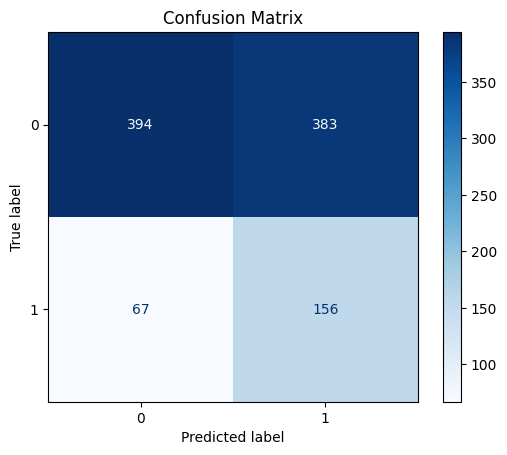

In [13]:
# test/evaluate on test split and compute precision/recall/F1
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

model.eval()
dataloader = torch.utils.data.DataLoader(tokenized["test"], batch_size=32)
y_true, y_pred = [], []

for batch in dataloader:
    inputs = {k: v.cuda() if torch.cuda.is_available() else v for k, v in batch.items() if k != "labels"}
    labels = batch["labels"].numpy()
    with torch.no_grad():
        outputs = model(**inputs)
    preds = outputs.logits.argmax(-1).cpu().numpy()
    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

# Print classification report
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()
